# ENN583 - Week 4 Prac - Estimating Camera Motion 

In this Prac notebook, you can experiment with the three different ways of estimating the camera motion based on feature correspondences.

Using the familiar sequence from the Kitti dataset, the notebook shows you how to implement the 2D-2D method based on the Essential Matrix. You can then refine this method by determining the absolute scale, which is typically missing from a purely monocular visual odometry system, but can be recovered here from the stereo information.

The later parts of this notebook let you investigate the 3D-3D method based on Arun's algorithm. An implementation is provided.
Finally, you can implement a 3D-2D correspondence pipeline and use the `solvePnP()` method to determine the camera motion between two frames.

### Setting Things Up
As always, we start by setting up the Kitti dataset object and import all required modules.

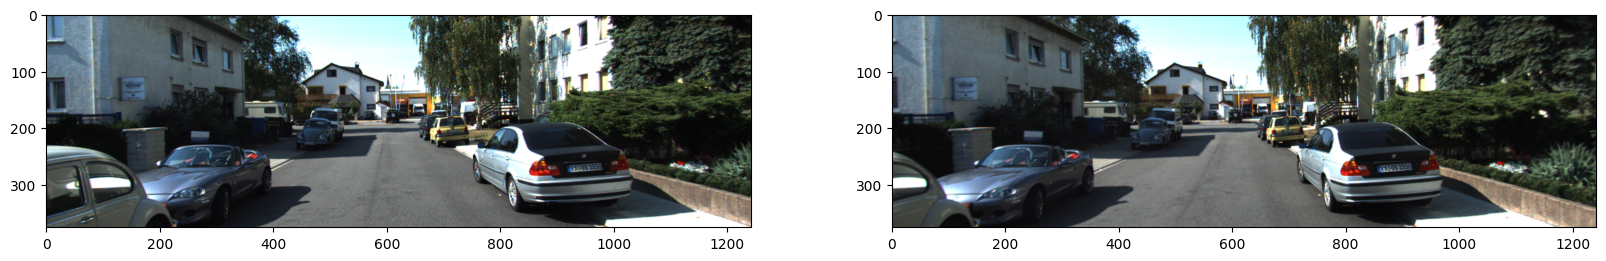

In [2]:
# Check if pykitti is installed, if not use pip to set it up
try:
    import pykitti
except ImportError:
    !pip install pykitti
    import pykitti

# Read the dataset sequence we just downloaded
basedir = '../kitti'
date = '2011_09_26'
drive = '0035'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# data = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))
data = pykitti.raw(basedir, date, drive)

import cv2
from matplotlib import pyplot as plt
import numpy as np

from spatialmath import *
from spatialmath.base import *
from spatialmath.base import sym
from spatialgeometry import *

# get the left and right stereo images from the 10th frame
left, right = data.get_rgb(10)
left = np.array(left)
right = np.array(right)

# use plt to show them side by side
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.show()

### Convenience Functions 
Here we define convenience functions for feature extraction and matching. Hint: If you want, you can implement different feature detectors / descriptors or matching algorithms here.

In [3]:
def detect_features(img, method='sift'):
    """Detect features in an image."""
    
    if method == 'sift':
        # detect features
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(img, None)
    elif method == 'orb':
        # detect features
        orb = cv2.ORB_create()
        kp, des = orb.detectAndCompute(img, None)
    else:
        # not implemented error
        raise NotImplementedError('Unknown feature detection method.')
        
    return kp, des

def match_features(des1, des2):
    """Match features between two images."""
    
    # match features
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    
    return matches

def disparity_map(img1, img2):
    stereo = cv2.StereoSGBM_create()
    disparity = stereo.compute(left, right)  
    disparity = disparity.astype(np.float32) / 16.0
    return disparity

## Motion from 2D-2D Correspondences

Here we use OpenCV's inbuilt functions to estimate the camera motion from 2D-2D correspondences. This example shows how to use the `findEssentialMat` and `recoverPose` functions. 

We expect two input images in grayscale format, along with the camera matrix K. The function returns a SE3 object from the spatial math toolbox.

In [4]:
def motion_from_2D2D(img1, img2, K):
    """Estimate the motion between two images using the 2D-2D method."""
    
    # detect features in both images
    kp1, des1 = detect_features(img1)
    kp2, des2 = detect_features(img2)

    # match features between the two images
    matches = match_features(des1, des2)

    # estimate the essential matrix
    E, mask = cv2.findEssentialMat(
        np.array([kp1[m.queryIdx].pt for m in matches]),
        np.array([kp2[m.trainIdx].pt for m in matches]),
        cameraMatrix=K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    # recover the pose from the essential matrix
    points, R, t, mask = cv2.recoverPose(E,
        np.array([kp1[m.queryIdx].pt for m in matches]),
        np.array([kp2[m.trainIdx].pt for m in matches]))
    
    # we return a SE3 object describing the pose of the second camera in the frame of the first camera
    # we also return the mask of inliers
    return SE3(t) * SE3(SO3(R)), mask

Let's use the function above to estimate the camera motion along a whole trajectory. This will take around 30 seconds for the example trajectory. 

In [5]:
# we will store the estimated frame-to-frame motion in this list
# this will contain SE3 objects describing the _relative_ motion of the camera from one frame to the next
relative_poses = []
relative_poses.append(SE3())    # put the first camera at the origin

# we will store the mask of inliers in this list
masks = []

# the intrinsic parameters of the left RGB camera
K = data.calib.K_cam2

# we iterate over all RGB images in the dataset
img1 = None

for left, right_ in data.rgb:

    # convert the image into opencv format and grayscale
    left = cv2.cvtColor(np.array(left), cv2.COLOR_RGB2GRAY)    

    # is this the first iteration?
    if img1 is None:
        img1 = left       
        continue
    else:
        # now img2 is the most recent image, img1 is the previous image
        img2 = left

        # estimate the motion between two cameras, returns a SE3 object
        # the SE3 is the pose of the second camera in the frame of the first camera
        T, mask = motion_from_2D2D(img1, img2, K)
        
        relative_poses.append(T)
        masks.append(mask)

        # img2 becomes the previous image for the next iteration
        img1 = img2    

        if len(relative_poses) % 25 == 0:
            print("Processed %d images" % len(relative_poses))



Processed 25 images
Processed 50 images
Processed 75 images
Processed 100 images
Processed 125 images


We now have the relative motion between the adjecent camera frames stored in the `relative_poses` array.

How can we compose a trajectory in world frame from this? Remember that the relative motion will always be relative to the camera frames. 

Also remember that the 2D2D method cannot give us the absolute scale of the translation, only the direction. We are going to cheat a little bit here and determine the absolute scale factor from the ground truth motion. 

**Your turn:**
 - Replace the cheating and find another way of establishing the scale factor.

Mean ATE: 	214.12 mm
Median ATE: 	159.48 mm
Max ATE: 	981.03 mm
RMSE: 		219.30 mm


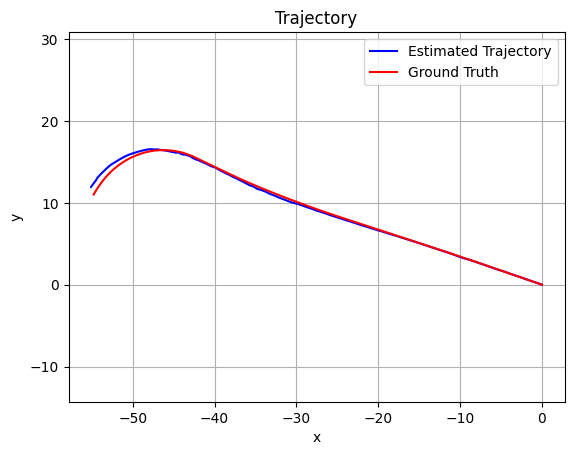

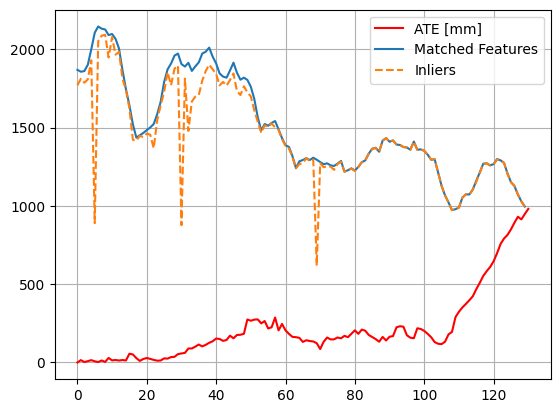

In [6]:

b = data.calib.b_rgb
f = data.calib.P_rect_20[0][0]

# Let's establish the position of the first camera in the world frame.
# We will assume that the first camera is looking along the x-axis of the world frame and is located at (0,0,0)
c1Rw = np.array([[0,-1,0],[0,0,-1],[1,0,0]])
c1Tw = SE3(SO3(c1Rw)) 
wTc1 = c1Tw.inv()       # this is the pose of camera 1 in the world frame, as seen by the world frame

# we will store the poses of the cameras in the world frame in this list
# initialise it with the pose of the first camera
trajectory = [wTc1]

# let's iterate over the relative poses and compute the poses in the world frame

for i, c2Tc1 in enumerate(relative_poses[1:]):     
    
    # recoverPose gives us the c2Tc1 transform, but we want the c1Tc2 transform. c1Tc2 gives us the pose of camera 2 in the frame of camera 1.
    c1Tc2 = c2Tc1.inv() 

    # cheat by getting the scale factor from the ground truth pose data
    d = SE3(data.oxts[i+1].T_w_imu).inv() * SE3(data.oxts[i].T_w_imu)   
    scale = np.linalg.norm(d.t)

    # ========
    # YOUR TURN! Find a way to compute the scale factor without using the ground truth data. Remember you have access to a stereo camera.
    # YOUR CODE HERE
    # left0, right0 = data.rgb[i-1]
    # disparity = disparity_map(left0, right0)
    
    # # find interest points
    # kp0, des0 = detect_features(left)
    # interest_disp = [disparity[pt] for pt in kp1]
    
    # # calc 3d coord
    # b = data.calib.b_rgb
    # f = data.calib.P_rect_20[0][0]
    # Z_p = b*f / interest_disp.astype(np.float32)
    # depth = Z_p.clip(0,20)
    # ========

    # scale the translation vector
    c1Tc2.t *= scale

    # if the camera is moving backwards (-z direction) we need to invert the relative pose
    # this should have been caught by OpenCV's recoverPose function (?)
    if c1Tc2.t[2] < 0:
        c1Tc2.t[2] *= -1
    
    # this is the pose of the current camera in the world frame
    trajectory.append(trajectory[-1] * c1Tc2)




# ===== PLOTTING =====

# the world frame is not aligned with the ground truth frame (we'll call it g), so let's 
# get the first ground truth pose and use that to align world and ground truth frames
gTw = SE3(data.oxts[0].T_w_imu)

# our trajectory now is in world frame, so let's transform it to the ground truth frame
trajectory = [gTw * T for T in trajectory]

# plot the estimated trajectory
traj = np.array([ [T.t[0] for T in trajectory], [T.t[1] for T in trajectory] ])
plt.plot(traj[0,:], traj[1,:],'b-', label='Estimated Trajectory')

# plot the ground truth into the same plot
gt = np.array([ [oxts.T_w_imu[0,3] for oxts in data.oxts], [oxts.T_w_imu[1,3] for oxts in data.oxts] ])
plt.plot(gt[0,:], gt[1,:],'r-', label='Ground Truth')
#  give the plot an aspect ratio so that both axes are scaled equally
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trajectory')
plt.grid()
plt.legend()

# we can also plot more information, such as the error between the estimated and ground truth trajectories
# we also plot information about the number of matches and inliners, returned in the `masks` array we got in the cell above
error = np.linalg.norm(traj - gt, axis=0)
plt.figure()
plt.plot(error*1000,'r', label='ATE [mm]')
plt.plot([len(m) for m in masks], label='Matched Features')
plt.plot([np.sum(m)/255 for m in masks], '--', label='Inliers')
plt.legend()
plt.grid()

# print some error metrics
# ATE = Absolute Pose Error (but we only calculate it on the XY plane here)
# RMSE = Root Mean Squared Error
print(f'Mean ATE: \t{np.mean(error)*1000:.2f} mm')
print(f'Median ATE: \t{np.median(error)*1000:.2f} mm')
print(f'Max ATE: \t{np.max(error)*1000:.2f} mm')
print(f'RMSE: \t\t{np.sqrt(np.mean((traj - gt)**2))*1000:.2f} mm')

## Motion from 3D-3D correspondences



In [7]:
def motion_from_3D3D(X,Y):
    """Implements Arun's method for computing the motion from two sets of 3D points.    
    This returns a transform c2Tc1 such that Y = c2Tc1 * X, where X are the points before motion (first camera) 
    and Y are points after motion (second camera). The method is described in Arun et al. (1987)    
    """

    # determine the centroid
    mean_X = np.mean(X, axis=1)
    mean_Y = np.mean(Y, axis=1)

    # get the centered coordinates by subtracting the centroid
    XX = X - mean_X.reshape(-1,1)
    YY = Y - mean_Y.reshape(-1,1)

    # compute the 3x3vcovariance matrix
    H = np.dot(XX,YY.T)

    # compute the SVD of the covariance matrix
    U, S, Vt = np.linalg.svd(H)

    # compute the rotation matrix from U and Vt
    R = np.dot(Vt.T, U.T)
    
    # check if the R is a reflection and correct if needed
    if np.linalg.det(R)<0:  # det(R) is 1 for a rotation and -1 for a reflection
        Vt[2,:] *= -1
        R = np.dot(Vt.T, U.T)

    # compute the translation vector
    t = mean_Y - R @ mean_X
    
    print(t)
    print(R)
    
    # return the transform c2Tc1
    return SE3(t) * SE3(SO3(R))



### Your Turn! - Implement the full 3D-3D motion estimation.

Use the above method to estimate the trajectory for the complete Kitti sequence.

Remember you have to first establish 3D points for each timestep. You have two options:

Option 1:
 - get the full disparity map
 - calculate interest points in the left image only
 - look up the disparity for your interest points
 - calculate the 3D coordinates for your interestpoints using the disparity
  
Option2:
 - match interest points between left and right image and calculate the disparity only for the matches points
 - calculate 3D coordinates using the disparity
  
You then have to establish correspondences across two timesteps, e.g beore and after the camera moved. To do this, you want to match interest points between the left images before and after the motion.

This gives you two sets of 3D points, including their correspondences.

Arun's method above then gives you the transform c2Tc1. Remember that you want the inverse, c1Tc2 do describe the relative camera motion.
Using the code from the 2D-2D method, comnbine the frame-to-frame motion estimates to calculate the motion for the complete trajectory.

Remember that incorrect feature matches (either between left and right, or between two left images) will be very harmful for the motion estimation. Consider using the Fundamental Matrix estimation with a RANSAC loop to remove outlier matches.



In [8]:
### YOUR CODE HERE
stereo = cv2.StereoSGBM_create()
frame1 = None
stereo_images = list(data.rgb)
for i, _ in enumerate(data.rgb):

    left_curr, right_curr = stereo_images[i]
    if (i == 0):
        left_prev = left_curr
        right_prev = right_curr
    else:
        left_prev, right_prev = stereo_images[i - 1]
        
    # convert the image into opencv format and grayscale
    left_curr = cv2.cvtColor(np.array(left_curr), cv2.COLOR_RGB2GRAY)    
    right_curr  = cv2.cvtColor(np.array(right_curr), cv2.COLOR_RGB2GRAY)
    left_prev = cv2.cvtColor(np.array(left_prev), cv2.COLOR_RGB2GRAY)    
    right_prev  = cv2.cvtColor(np.array(right_prev), cv2.COLOR_RGB2GRAY)
    
    # detect features
    kp_Lprev, des_Lprev = detect_features(left_prev)
    kp_Rprev, des_Rprev = detect_features(right_prev)
    kp_Lcurr, des_Lcurr = detect_features(left_curr)
    kp_Rcurr, des_Rcurr = detect_features(right_curr)

    # find features within L-R
    disparity_LR = disparity_map(des_Lcurr, des_Rcurr)
    print(disparity_LR)
    
    # find which features exist Lprev-L
    
    
    # # calc 3d coord
    # b = data.calib.b_rgb
    # f = data.calib.P_rect_20[0][0]
    # Z_p = b*f / disparity1.astype(np.float32)
    # depth = Z_p.clip(0,20)
    
    if frame1 is None:
        frame1 = left    
        continue
    else:
        frame2 = left

    T = motion_from_3D3D(frame1, frame2)
    
    relative_poses.append(T)
    masks.append(mask)

    # img2 becomes the previous image for the next iteration
    img1 = img2    

    if len(relative_poses) % 25 == 0:
        print("Processed %d images" % len(relative_poses))
    break


error: OpenCV(4.7.0) /io/opencv/modules/calib3d/src/stereosgbm.cpp:2210: error: (-215:Assertion failed) left.size() == right.size() && left.type() == right.type() && left.depth() == CV_8U in function 'compute'


## Motion Estimation from 3D-2D Correspondences

3D-2D based motion estimation refers to finding the pose of a camera given a set of 3D points in the world and their corresponding 2D projections in the image. This problem is often referred to as Perspective-n-Point (PnP), and OpenCV provides a function called `cv2.solvePnP` to handle this.

Using a stereo camera system for motion estimation offers some distinct advantages. With a stereo setup, you can obtain depth information for each image point by triangulating corresponding points from the two camera views. This allows you to estimate 3D points from 2D observations, which you can then use in the `solvePnP()` method to estimate the camera's motion.

Here is an outline of the process:

1. **Compute the Disparity Map:** For each pair of stereo images, compute the disparity map, which provides the displacement of each pixel between the two views.
2. **Triangulate 3D Points:** Using the disparity map and the calibration data, you can triangulate the 3D coordinates of the points. Hint: Think about which coordinate system these points appear in and transform them into a different reference frame if needed.
3. **Match 3D Points with 2D Points:** In the new image from one of the cameras (e.g. the left camera), detect and match 2D points with the previously triangulated 3D points.
4. **Use `solvePnP()` to Estimate Motion:** With the matched 3D-2D points, use solvePnP() to estimate the motion of the camera.

### Your Turn!
Implement a frame-to-frame PnP-based motion estimator.

In [ ]:
### YOUR CODE HERE